# BlueTrails AI - Water Quality Prediction (RNN Models V3)

**New Approach: Recurrent Neural Networks for Time-Series**

**Why RNNs?**
- Water quality has **temporal dependencies** (seasonal patterns, trends)
- Sequential data from monitoring sites over time
- Can capture **historical context** better than MLP

**Architectures to Compare:**
1. **GRU (Gated Recurrent Unit)** - Lighter, faster, fewer parameters
2. **LSTM (Long Short-Term Memory)** - More complex, better for long-term dependencies

**Strategy:**
- Train BOTH architectures for each parameter
- Compare performance (R², RMSE, MAE)
- Select best model per parameter

**Target Parameters:**
1. CHL_A (Chlorophyll A)
2. Turbidity
3. DO_mg_l (Dissolved Oxygen)
4. N_TOTAL (Total Nitrogen)
5. Temperature

## 1. Setup & Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Scikit-learn
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supabase
from supabase import create_client, Client

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.8.0+cpu
Device: CPU


## 2. Load Data from Supabase

In [2]:
load_dotenv('../.env')

SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in .env file")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✓ Connected to Supabase")

✓ Connected to Supabase


In [3]:
# Fetch data
response = supabase.table('v_epa_measurements_wide').select('*').execute()
df_raw = pd.DataFrame(response.data)

response_sites = supabase.table('v_epa_sites').select('*').execute()
df_sites = pd.DataFrame(response_sites.data)

print(f"Loaded {len(df_raw)} measurements from {df_raw['site_id'].nunique()} sites")
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")

Loaded 5853 measurements from 21 sites
Date range: 1984-07-19 to 2025-06-20


## 3. Data Preprocessing

In [4]:
# Filter to surface measurements and merge with site metadata
df = df_raw[df_raw['measurement_type'] == 'surface'].copy()
df = df.merge(df_sites[['site_id', 'latitude', 'longitude', 'water_body_name']], 
              on='site_id', how='left', suffixes=('', '_site'))

df['latitude'] = df['latitude_site'].fillna(df['latitude'])
df['longitude'] = df['longitude_site'].fillna(df['longitude'])
df = df.drop(['latitude_site', 'longitude_site'], axis=1, errors='ignore')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Define target parameters
df['temperature'] = df['temp_sensor'].fillna(df['temp_lab'])
TARGET_PARAMS = ['chl_a', 'turbidity', 'do_mg_l', 'n_total', 'temperature']

print(f"Working with {len(df)} surface measurements")

Working with 4492 surface measurements


## 4. Feature Engineering for RNN

In [5]:
# Temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['season'] = df['month'].apply(lambda m: 
    1 if m in [12, 1, 2] else 2 if m in [3, 4, 5] else 3 if m in [6, 7, 8] else 4
)

# Cyclic encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

# Encode categorical features
site_encoder = LabelEncoder()
df['site_id_encoded'] = site_encoder.fit_transform(df['site_id'])

water_body_encoder = LabelEncoder()
df['water_body_encoded'] = water_body_encoder.fit_transform(df['water_body_name'].fillna('Unknown'))

print("✓ Features created")

✓ Features created


In [6]:
# Sort by site and date
df = df.sort_values(['site_id', 'date']).reset_index(drop=True)

# Core features for RNN (no lag features - RNN will learn temporal patterns)
FEATURE_COLS = [
    'site_id_encoded', 'water_body_encoded', 'latitude', 'longitude',
    'year', 'month', 'season',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
]

print(f"Total features: {len(FEATURE_COLS)}")

Total features: 11


## 5. Sequence Preparation for RNN

RNNs need sequences of data. We'll use a sliding window approach:
- **Sequence length**: 5 time steps (previous 5 measurements)
- **Target**: Predict next value
- Group by site to maintain temporal continuity

In [7]:
def create_sequences(df, param, features, seq_length=5):
    """
    Create sequences for RNN training.
    
    Args:
        df: Dataframe with features and target
        param: Target parameter name
        features: List of feature column names
        seq_length: Number of time steps in each sequence
    
    Returns:
        X_seq: Array of shape (n_samples, seq_length, n_features)
        y: Array of shape (n_samples,)
    """
    # Filter to rows where target is not null
    df_param = df[df[param].notna()].copy()
    
    X_seq_list = []
    y_list = []
    
    # Create sequences per site
    for site_id in df_param['site_id'].unique():
        site_data = df_param[df_param['site_id'] == site_id].sort_values('date')
        
        # Extract features and target
        X_site = site_data[features].values
        y_site = site_data[param].values
        
        # Create sequences using sliding window
        for i in range(len(site_data) - seq_length):
            X_seq_list.append(X_site[i:i+seq_length])
            y_list.append(y_site[i+seq_length])
    
    X_seq = np.array(X_seq_list)
    y = np.array(y_list)
    
    return X_seq, y

print("✓ Sequence creation function defined")

✓ Sequence creation function defined


In [8]:
# Impute missing values in features
imputer = SimpleImputer(strategy='median')
df[FEATURE_COLS] = imputer.fit_transform(df[FEATURE_COLS])

print("✓ Missing values imputed")

✓ Missing values imputed


## 6. Prepare Data for Each Parameter

In [9]:
def prepare_rnn_data(df, param, features, seq_length=5, test_size=0.15, val_size=0.15):
    """
    Prepare train/val/test data for RNN.
    """
    print(f"\n{'='*60}")
    print(f"Preparing RNN data for: {param.upper()}")
    print(f"{'='*60}")
    
    # Create sequences
    X_seq, y = create_sequences(df, param, features, seq_length)
    
    print(f"Total sequences: {len(X_seq)}")
    print(f"Sequence shape: {X_seq.shape}")
    
    # Temporal split (no shuffle to maintain time order)
    n = len(X_seq)
    train_size = int((1 - test_size - val_size) * n)
    val_size_n = int(val_size * n)
    
    X_train = X_seq[:train_size]
    y_train = y[:train_size]
    
    X_val = X_seq[train_size:train_size+val_size_n]
    y_val = y[train_size:train_size+val_size_n]
    
    X_test = X_seq[train_size+val_size_n:]
    y_test = y[train_size+val_size_n:]
    
    print(f"Train: {len(X_train)} sequences ({len(X_train)/n*100:.1f}%)")
    print(f"Val:   {len(X_val)} sequences ({len(X_val)/n*100:.1f}%)")
    print(f"Test:  {len(X_test)} sequences ({len(X_test)/n*100:.1f}%)")
    
    # Scale features (per feature across all sequences)
    # Reshape to (n_samples * seq_length, n_features) for scaling
    n_samples_train, seq_len, n_features = X_train.shape
    
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, n_features))
    X_train_scaled = X_train_scaled.reshape(n_samples_train, seq_len, n_features)
    
    X_val_scaled = scaler_X.transform(X_val.reshape(-1, n_features))
    X_val_scaled = X_val_scaled.reshape(len(X_val), seq_len, n_features)
    
    X_test_scaled = scaler_X.transform(X_test.reshape(-1, n_features))
    X_test_scaled = X_test_scaled.reshape(len(X_test), seq_len, n_features)
    
    # Scale target
    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    print(f"✓ Scaling complete")
    
    return {
        'X_train': X_train_scaled,
        'y_train': y_train_scaled,
        'X_val': X_val_scaled,
        'y_val': y_val_scaled,
        'X_test': X_test_scaled,
        'y_test': y_test_scaled,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'y_test_original': y_test,
    }

# Prepare data for all parameters
SEQ_LENGTH = 5
param_data = {}

for param in TARGET_PARAMS:
    param_data[param] = prepare_rnn_data(df, param, FEATURE_COLS, seq_length=SEQ_LENGTH)


Preparing RNN data for: CHL_A
Total sequences: 4327
Sequence shape: (4327, 5, 11)
Train: 3028 sequences (70.0%)
Val:   649 sequences (15.0%)
Test:  650 sequences (15.0%)
✓ Scaling complete

Preparing RNN data for: TURBIDITY
Total sequences: 1504
Sequence shape: (1504, 5, 11)
Train: 1052 sequences (69.9%)
Val:   225 sequences (15.0%)
Test:  227 sequences (15.1%)
✓ Scaling complete

Preparing RNN data for: DO_MG_L
Total sequences: 4146
Sequence shape: (4146, 5, 11)
Train: 2902 sequences (70.0%)
Val:   621 sequences (15.0%)
Test:  623 sequences (15.0%)
✓ Scaling complete

Preparing RNN data for: N_TOTAL
Total sequences: 4330
Sequence shape: (4330, 5, 11)
Train: 3031 sequences (70.0%)
Val:   649 sequences (15.0%)
Test:  650 sequences (15.0%)
✓ Scaling complete

Preparing RNN data for: TEMPERATURE
Total sequences: 4026
Sequence shape: (4026, 5, 11)
Train: 2818 sequences (70.0%)
Val:   603 sequences (15.0%)
Test:  605 sequences (15.0%)
✓ Scaling complete


## 7. Define RNN Architectures

In [10]:
class GRUPredictor(nn.Module):
    """
    GRU-based predictor for water quality parameters.
    Lighter and faster than LSTM.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(GRUPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # GRU layers
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        gru_out, _ = self.gru(x)
        # Take output from last time step
        last_out = gru_out[:, -1, :]
        # Pass through FC layers
        out = self.fc(last_out)
        return out.squeeze()


class LSTMPredictor(nn.Module):
    """
    LSTM-based predictor for water quality parameters.
    Better for long-term dependencies.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # Take output from last time step
        last_out = lstm_out[:, -1, :]
        # Pass through FC layers
        out = self.fc(last_out)
        return out.squeeze()

print("✓ GRU and LSTM architectures defined")
print(f"\nGRU: Input → GRU(64, 2 layers) → FC(32) → Output")
print(f"LSTM: Input → LSTM(64, 2 layers) → FC(32) → Output")

✓ GRU and LSTM architectures defined

GRU: Input → GRU(64, 2 layers) → FC(32) → Output
LSTM: Input → LSTM(64, 2 layers) → FC(32) → Output


## 8. Training Function

In [11]:
def train_rnn_model(model_type, param_name, data_dict, input_dim, epochs=100, patience=15, lr=0.001):
    """
    Train RNN model (GRU or LSTM).
    """
    print(f"\n{'='*70}")
    print(f"TRAINING {model_type.upper()} FOR: {param_name.upper()}")
    print(f"{'='*70}")
    
    # Prepare data loaders
    batch_size = 32
    
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(data_dict['X_train']),
        torch.FloatTensor(data_dict['y_train'])
    )
    val_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(data_dict['X_val']),
        torch.FloatTensor(data_dict['y_val'])
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if model_type.lower() == 'gru':
        model = GRUPredictor(input_dim, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
    else:
        model = LSTMPredictor(input_dim, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
    
    # Loss and optimizer
    criterion = nn.HuberLoss(delta=1.0)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training loop
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} - Train: {train_loss:.6f} - Val: {val_loss:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_model_state)
    
    print(f"\n✓ Training complete! Best val loss: {best_val_loss:.6f}")
    
    return model, history

print("✓ Training function defined")

✓ Training function defined


## 9. Train Both GRU and LSTM for All Parameters

In [12]:
# Train both architectures for each parameter
INPUT_DIM = len(FEATURE_COLS)

gru_models = {}
lstm_models = {}
gru_histories = {}
lstm_histories = {}

for param in TARGET_PARAMS:
    # Train GRU
    gru_models[param], gru_histories[param] = train_rnn_model(
        'GRU', param, param_data[param], INPUT_DIM, epochs=100, patience=15, lr=0.001
    )
    
    # Train LSTM
    lstm_models[param], lstm_histories[param] = train_rnn_model(
        'LSTM', param, param_data[param], INPUT_DIM, epochs=100, patience=15, lr=0.001
    )


TRAINING GRU FOR: CHL_A
Epoch   1/100 - Train: 0.566867 - Val: 0.072906
Epoch  10/100 - Train: 0.462144 - Val: 0.054189
Epoch  20/100 - Train: 0.443704 - Val: 0.048963

Early stopping at epoch 27

✓ Training complete! Best val loss: 0.047828

TRAINING LSTM FOR: CHL_A
Epoch   1/100 - Train: 0.573300 - Val: 0.080594
Epoch  10/100 - Train: 0.457633 - Val: 0.048721
Epoch  20/100 - Train: 0.446470 - Val: 0.050493

Early stopping at epoch 23

✓ Training complete! Best val loss: 0.045523

TRAINING GRU FOR: TURBIDITY
Epoch   1/100 - Train: 1.097527 - Val: 0.452051
Epoch  10/100 - Train: 0.841149 - Val: 0.572301

Early stopping at epoch 16

✓ Training complete! Best val loss: 0.452051

TRAINING LSTM FOR: TURBIDITY
Epoch   1/100 - Train: 1.104620 - Val: 0.398320
Epoch  10/100 - Train: 0.818495 - Val: 0.517033

Early stopping at epoch 16

✓ Training complete! Best val loss: 0.398320

TRAINING GRU FOR: DO_MG_L
Epoch   1/100 - Train: 0.279516 - Val: 0.127531
Epoch  10/100 - Train: 0.228916 - Val: 

## 10. Evaluate Both Architectures

In [13]:
def evaluate_rnn_model(model, data_dict):
    """
    Evaluate RNN model on test set.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    X_test_tensor = torch.FloatTensor(data_dict['X_test']).to(device)
    
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).cpu().numpy()
    
    # Inverse transform
    y_pred = data_dict['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = data_dict['y_test_original']
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'y_true': y_true,
        'y_pred': y_pred,
    }

# Evaluate all models
gru_results = {}
lstm_results = {}

for param in TARGET_PARAMS:
    gru_results[param] = evaluate_rnn_model(gru_models[param], param_data[param])
    lstm_results[param] = evaluate_rnn_model(lstm_models[param], param_data[param])

print("✓ All models evaluated")

✓ All models evaluated


## 11. Compare Results: GRU vs LSTM vs MLP (V3)

In [14]:
# V3 (MLP) results for comparison
v3_results = {
    'chl_a': {'r2': 0.2103, 'rmse': 6.4736, 'mae': 3.0408},
    'turbidity': {'r2': 0.3711, 'rmse': 7.9823, 'mae': 2.4348},
    'do_mg_l': {'r2': 0.3099, 'rmse': 10.0504, 'mae': 1.4385},
    'n_total': {'r2': 0.2992, 'rmse': 588.7017, 'mae': 194.2183},
    'temperature': {'r2': 0.8747, 'rmse': 1.4848, 'mae': 1.1359},
}

# Create comparison table
comparison_data = []
for param in TARGET_PARAMS:
    comparison_data.append({
        'Parameter': param.upper(),
        'MLP (V3) R²': v3_results[param]['r2'],
        'GRU R²': gru_results[param]['r2'],
        'LSTM R²': lstm_results[param]['r2'],
        'Best Model': 'GRU' if gru_results[param]['r2'] > lstm_results[param]['r2'] else 'LSTM',
        'Best R²': max(gru_results[param]['r2'], lstm_results[param]['r2']),
        'Improvement vs MLP': max(gru_results[param]['r2'], lstm_results[param]['r2']) - v3_results[param]['r2'],
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("PERFORMANCE COMPARISON: GRU vs LSTM vs MLP (V3)")
print("="*90)
print(comparison_df.to_string(index=False))
print("\n" + "="*90)

# Print detailed results
print("\n" + "="*90)
print("DETAILED RESULTS - GRU")
print("="*90)
for param in TARGET_PARAMS:
    res = gru_results[param]
    print(f"\n{param.upper()}:")
    print(f"  RMSE: {res['rmse']:10.4f}")
    print(f"  MAE:  {res['mae']:10.4f}")
    print(f"  R²:   {res['r2']:10.4f}")
    print(f"  MAPE: {res['mape']:10.2f}%")

print("\n" + "="*90)
print("DETAILED RESULTS - LSTM")
print("="*90)
for param in TARGET_PARAMS:
    res = lstm_results[param]
    print(f"\n{param.upper()}:")
    print(f"  RMSE: {res['rmse']:10.4f}")
    print(f"  MAE:  {res['mae']:10.4f}")
    print(f"  R²:   {res['r2']:10.4f}")
    print(f"  MAPE: {res['mape']:10.2f}%")


PERFORMANCE COMPARISON: GRU vs LSTM vs MLP (V3)
  Parameter  MLP (V3) R²    GRU R²   LSTM R² Best Model   Best R²  Improvement vs MLP
      CHL_A       0.2103 -0.571602 -0.351231       LSTM -0.351231           -0.561531
  TURBIDITY       0.3711 -0.651674 -0.593516       LSTM -0.593516           -0.964616
    DO_MG_L       0.3099 -0.077212  0.006519       LSTM  0.006519           -0.303381
    N_TOTAL       0.2992 -1.755249 -2.126105        GRU -1.755249           -2.054449
TEMPERATURE       0.8747  0.704854  0.701524        GRU  0.704854           -0.169846


DETAILED RESULTS - GRU

CHL_A:
  RMSE:     2.0268
  MAE:      1.4507
  R²:      -0.5716
  MAPE: 49430530.37%

TURBIDITY:
  RMSE:    11.4365
  MAE:      7.2266
  R²:      -0.6517
  MAPE:      91.95%

DO_MG_L:
  RMSE:     1.4229
  MAE:      0.8207
  R²:      -0.0772
  MAPE:       9.64%

N_TOTAL:
  RMSE:   194.6179
  MAE:    144.5229
  R²:      -1.7552
  MAPE:      54.17%

TEMPERATURE:
  RMSE:     2.2040
  MAE:      1.6595
  R²:    

## 12. Visualize Comparison

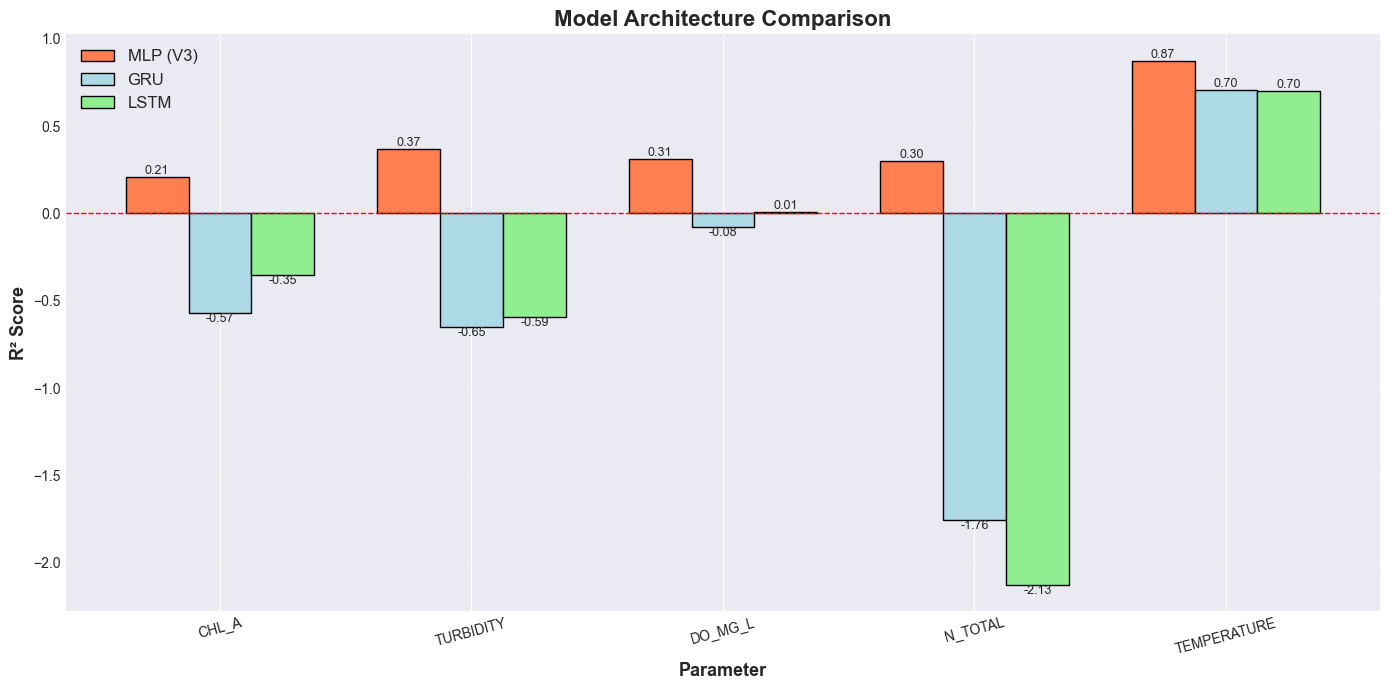

In [15]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(TARGET_PARAMS))
width = 0.25

mlp_r2 = [v3_results[p]['r2'] for p in TARGET_PARAMS]
gru_r2 = [gru_results[p]['r2'] for p in TARGET_PARAMS]
lstm_r2 = [lstm_results[p]['r2'] for p in TARGET_PARAMS]

bars1 = ax.bar(x - width, mlp_r2, width, label='MLP (V3)', color='coral', edgecolor='black')
bars2 = ax.bar(x, gru_r2, width, label='GRU', color='lightblue', edgecolor='black')
bars3 = ax.bar(x + width, lstm_r2, width, label='LSTM', color='lightgreen', edgecolor='black')

ax.set_xlabel('Parameter', fontsize=13, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=13, fontweight='bold')
ax.set_title('Model Architecture Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([p.upper() for p in TARGET_PARAMS], rotation=15)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

## 13. Save Best Models

In [16]:
import pickle

# Save best model for each parameter
for param in TARGET_PARAMS:
    # Determine best model
    if gru_results[param]['r2'] > lstm_results[param]['r2']:
        best_model = gru_models[param]
        best_type = 'GRU'
        best_results = gru_results[param]
    else:
        best_model = lstm_models[param]
        best_type = 'LSTM'
        best_results = lstm_results[param]
    
    model_artifact = {
        'model_state_dict': best_model.state_dict(),
        'model_type': best_type,
        'model_architecture': {
            'input_dim': INPUT_DIM,
            'hidden_dim': 64,
            'num_layers': 2,
            'dropout': 0.3,
            'seq_length': SEQ_LENGTH,
        },
        'scaler_X': param_data[param]['scaler_X'],
        'scaler_y': param_data[param]['scaler_y'],
        'features': FEATURE_COLS,
        'test_metrics': best_results,
    }
    
    torch.save(model_artifact, f'../model/internal/v3/{param}_rnn_model.pth')
    print(f"✓ Saved {best_type} model for {param}: ../model/internal/v3/{param}_rnn_model.pth (R²={best_results['r2']:.4f})")

# Save encoders
with open('../model/internal/v3/encoders_rnn.pkl', 'wb') as f:
    pickle.dump({
        'site_encoder': site_encoder,
        'water_body_encoder': water_body_encoder,
    }, f)

print("\n✓ All best RNN models and encoders saved!")

✓ Saved LSTM model for chl_a: ../model/internal/v3/chl_a_rnn_model.pth (R²=-0.3512)
✓ Saved LSTM model for turbidity: ../model/internal/v3/turbidity_rnn_model.pth (R²=-0.5935)
✓ Saved LSTM model for do_mg_l: ../model/internal/v3/do_mg_l_rnn_model.pth (R²=0.0065)
✓ Saved GRU model for n_total: ../model/internal/v3/n_total_rnn_model.pth (R²=-1.7552)
✓ Saved GRU model for temperature: ../model/internal/v3/temperature_rnn_model.pth (R²=0.7049)

✓ All best RNN models and encoders saved!


## 14. Summary & Recommendations

In [19]:
print("\n" + "="*90)
print("FINAL SUMMARY - RNN MODELS (V3)")
print("="*90)

print("\n📊 BEST MODEL PER PARAMETER:")
for param in TARGET_PARAMS:
    if gru_results[param]['r2'] > lstm_results[param]['r2']:
        best = 'GRU'
        r2 = gru_results[param]['r2']
    else:
        best = 'LSTM'
        r2 = lstm_results[param]['r2']
    
    improvement = r2 - v3_results[param]['r2']
    symbol = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
    
    print(f"  {symbol} {param.upper():15} - {best:4} (R²={r2:.4f}, change: {improvement:+.4f})")

avg_gru_r2 = np.mean([gru_results[p]['r2'] for p in TARGET_PARAMS])
avg_lstm_r2 = np.mean([lstm_results[p]['r2'] for p in TARGET_PARAMS])
avg_v3_r2 = np.mean([v3_results[p]['r2'] for p in TARGET_PARAMS])

print(f"\n📈 AVERAGE R² SCORES:")
print(f"  MLP (V3):  {avg_v3_r2:.4f}")
print(f"  GRU (V4):  {avg_gru_r2:.4f}")
print(f"  LSTM (V4): {avg_lstm_r2:.4f}")

print("\n🎯 RECOMMENDATIONS:")
if avg_gru_r2 > avg_v3_r2 or avg_lstm_r2 > avg_v3_r2:
    print("  ✅ RNN models show improvement - USE V3 models for production")
    print("  ✅ RNNs better capture temporal patterns in water quality data")
else:
    print("  ⚠️ RNN models didn't improve overall - stick with V2 MLP models")
    print("  ⚠️ Consider that temporal patterns may not be strong in this dataset")

print("\n💡 NEXT STEPS:")
print("  1. Use best model per parameter (saved in ../model/internal/v3/)")
print("  2. Integrate with backend API for predictions")
print("  3. Consider ensemble: combine RNN + MLP predictions")
print("  4. Add external data (weather, tides) if available")

print("\n" + "="*90)


FINAL SUMMARY - RNN MODELS (V3)

📊 BEST MODEL PER PARAMETER:
  📉 CHL_A           - LSTM (R²=-0.3512, change: -0.5615)
  📉 TURBIDITY       - LSTM (R²=-0.5935, change: -0.9646)
  📉 DO_MG_L         - LSTM (R²=0.0065, change: -0.3034)
  📉 N_TOTAL         - GRU  (R²=-1.7552, change: -2.0544)
  📉 TEMPERATURE     - GRU  (R²=0.7049, change: -0.1698)

📈 AVERAGE R² SCORES:
  MLP (V3):  0.4130
  GRU (V4):  -0.4702
  LSTM (V4): -0.4726

🎯 RECOMMENDATIONS:
  ⚠️ RNN models didn't improve overall - stick with V2 MLP models
  ⚠️ Consider that temporal patterns may not be strong in this dataset

💡 NEXT STEPS:
  1. Use best model per parameter (saved in ../model/internal/v3/)
  2. Integrate with backend API for predictions
  3. Consider ensemble: combine RNN + MLP predictions
  4. Add external data (weather, tides) if available

